In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd



import numpy as np
import matplotlib.pyplot as plt


from glob import glob

import os, sys

sys.path.append('/Users/silas/Documents/switchdrive/')
import helper_scripts as hs

from io import StringIO


import seaborn as sns
#from helper_scripts import DimensionalReduction,MetaTable
from helper_scripts import effect_plot as EP




In [4]:
working_dir='../WD/'

In [5]:
metadata= pd.read_table(f'../metadata.tsv',index_col=0)

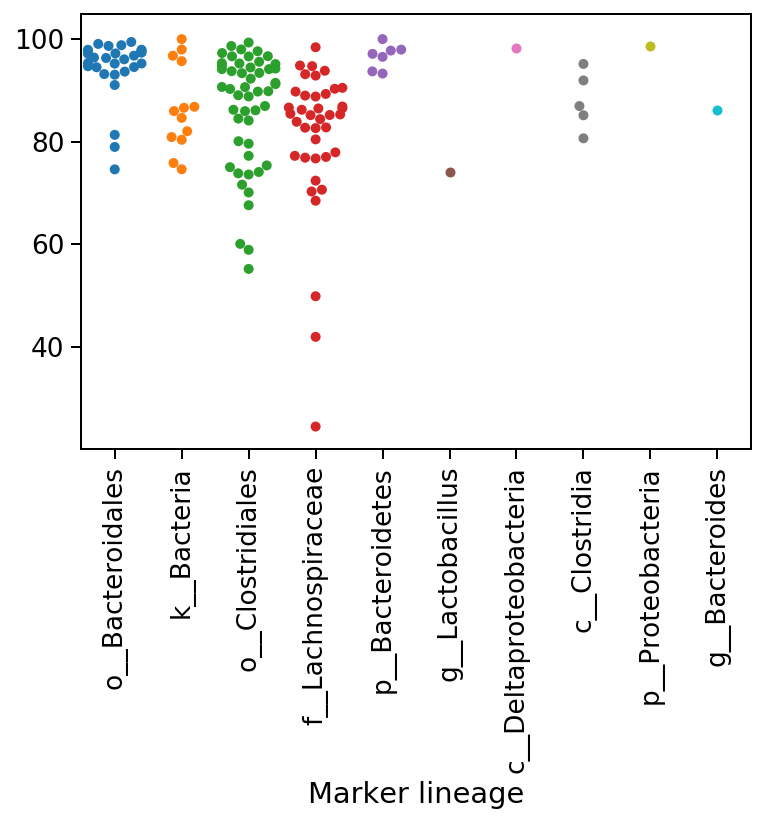

In [10]:
GenomeInfo= pd.concat((pd.read_table(f'{working_dir}/genomes/checkm/completeness.tsv',index_col=0),
                     pd.read_table(f'{working_dir}/genomes/checkm/taxonomy.tsv',index_col=0)),1).dropna(how='all',axis=1)



checkmTax = pd.DataFrame(list(GenomeInfo['Taxonomy (contained)'].apply(lambda s: s.split(';'))),
                       index=GenomeInfo.index)
checkmTax.columns=['Kindom','Phylum','Class','Order','Family','Genus']


ax=sns.swarmplot(y=GenomeInfo.Completeness-5*GenomeInfo.Contamination,x=GenomeInfo['Marker lineage'].map(lambda s: s.split()[0]))
_ =ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [11]:
DT= pd.read_table(f'{working_dir}/genomes/taxonomy/taxonomy_names.tsv')
DT= DT.drop_duplicates(['# bin']).sort_values('# bin')

DT.index= DT['# bin']

Tax= DT.loc[:,'superkingdom':].fillna('not classified')
Tax= Tax.applymap(lambda s: s.split(':')[0])
Tax= Tax.replace('not classified',np.nan)
Tax=Tax.fillna(method='ffill',axis=1)

Labels=Tax.species+' '+Tax.index

# Gene cluster

In [12]:
Clusters= pd.read_csv('../WD/genomes/clustering/orf_2_genome.tsv',sep='\t',index_col=0)

In [13]:
Clusters.head()

,Gene,Contig,KO,Bin,Genome
ORF,,,,,
shRTF1_0_1,Gene0000001,shRTF1_0,K02584,shRTF1_maxbin_005,MAG038
shRTF1_0_2,Gene0000002,shRTF1_0,NaN,shRTF1_maxbin_005,MAG038
shRTF1_0_3,Gene0000003,shRTF1_0,K01915,shRTF1_maxbin_005,MAG038
shRTF1_0_4,Gene0000004,shRTF1_0,K01912,shRTF1_maxbin_005,MAG038
shRTF1_0_5,Gene0000005,shRTF1_0,K09765,shRTF1_maxbin_005,MAG038


In [14]:
K= Clusters.groupby(['Genome','KO']).size().unstack().fillna(0)

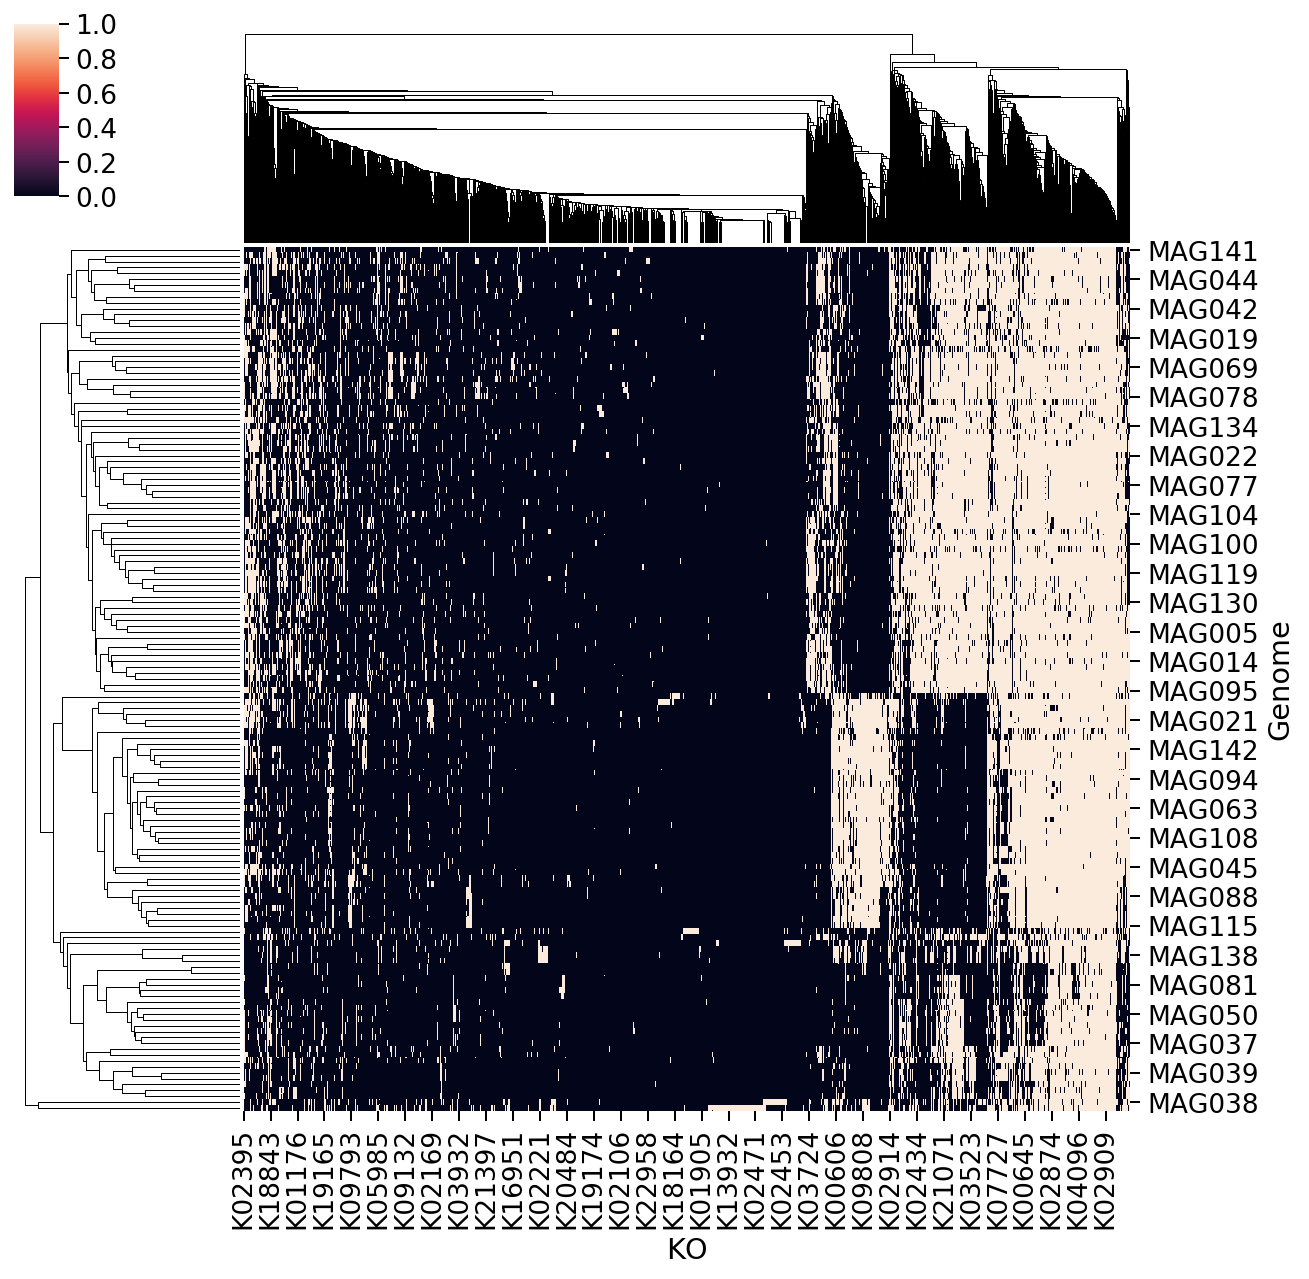

In [10]:
sns.clustermap(K>0)

In [16]:
I= K

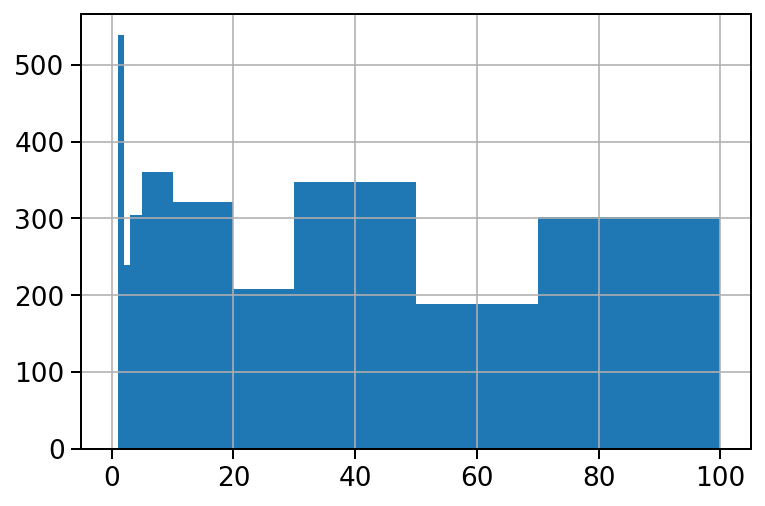

In [17]:
I.sum().hist(bins=[0,1,2,3,5,10,20,30,50,70,100])

In [18]:
Description= pd.Series(I.columns, index=I.columns)

In [19]:
Description=Description.loc[~(Description.index.duplicated()| Description.index.isnull())]

## PCA on genes

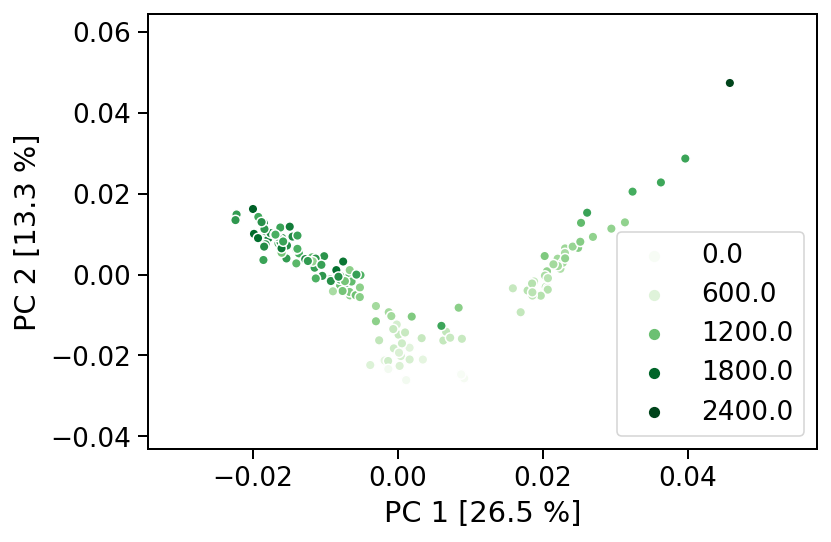

In [15]:


DR =DimensionalReduction.DimensionalReduction((I.T/I.sum(1)).T) #((I.T-I.mean(1))/I.std(1)).T)

pl=DR.plot_Components_2D(hue = I.sum(1),palette='Greens')


plt.show()

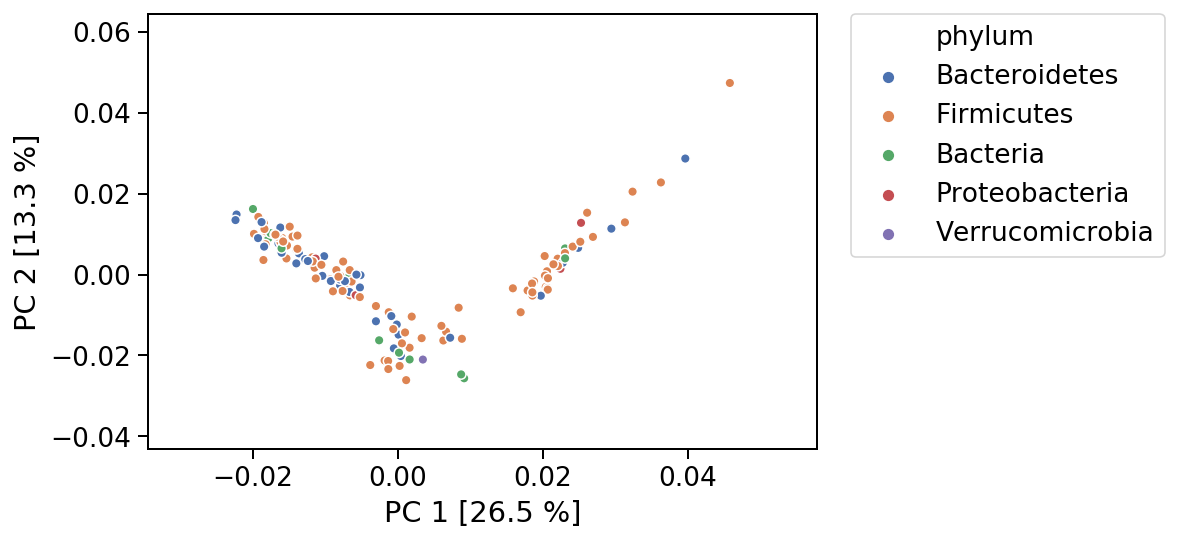

In [16]:

DR.plot_Components_2D(hue=Tax.phylum,palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

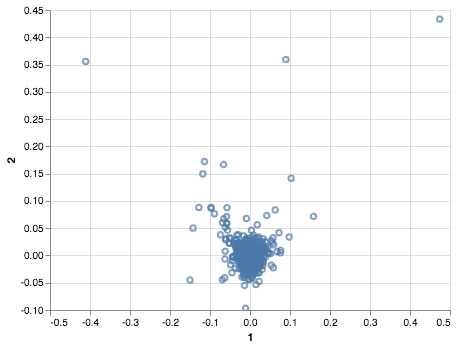

In [17]:

DimensionalReduction.altair_plot2D(DR.components.T)

# aggregate genes

In [35]:
presence_absence= (I>0)*1.
presence_absence= presence_absence.loc[:,presence_absence.std()>0]


## Relab

In [36]:
#D = pd.read_table(f'../bins/{bin_folder}/counts/normalized_counts.tsv',index_col=0)
D = pd.read_table(f'{working_dir}/genomes/counts/median_coverage_genomes.tsv',index_col=0)


D = (D.T/D.sum(1)).T
D.head()

,MAG001,MAG002,MAG003,MAG004,MAG005,MAG006,MAG007,MAG008,MAG009,MAG010,...,MAG138,MAG139,MAG140,MAG141,MAG142,MAG143,MAG144,MAG145,MAG146,MAG147
shHC1,0.046398,0.013608,0.000000,0.001478,0.012896,0.001948,0.000134,0.007039,0.000000,0.000000,...,0.005810,0.008100,0.000148,0.003519,0.004930,0.007845,0.0,0.005615,0.004245,0.000000
shHC2,0.033744,0.011312,0.000000,0.000177,0.001376,0.005233,0.000341,0.000000,0.000313,0.000000,...,0.002099,0.013369,0.000000,0.002562,0.000000,0.006378,0.0,0.004347,0.007400,0.000273
shHC3,0.059028,0.015640,0.000000,0.000324,0.008006,0.000324,0.000000,0.000000,0.000000,0.000648,...,0.014943,0.011702,0.003436,0.003209,0.002318,0.004019,0.0,0.004198,0.001264,0.000000
shHC4,0.022808,0.016684,0.000000,0.001223,0.003641,0.001594,0.000000,0.000000,0.000000,0.000000,...,0.003507,0.010774,0.000148,0.000000,0.000000,0.017470,0.0,0.007356,0.007741,0.000000
shHC5,0.046114,0.013777,0.000371,0.000742,0.008381,0.000742,0.001669,0.000000,0.000000,0.000000,...,0.007788,0.006508,0.000408,0.003764,0.001854,0.001038,0.0,0.006508,0.000723,0.000371


In [37]:
Prevalence= (D.loc[:,presence_absence.index]>0.01).astype(int)@presence_absence

mean_prefelance= Prevalence.groupby([metadata.Group,metadata.Source]).mean().T

(mean_prefelance.Hot/mean_prefelance.RT).loc[mean_prefelance.Hot.Feces>=1].sort_values('Feces',ascending=False)

#mean_prefelance.loc['K01048']

Source,Cecum,Feces
KO,,
K16928,inf,inf
K15739,inf,inf
K00066,inf,inf
K03930,inf,inf
K07406,4.000000,inf
...,...,...
K00030,0.357143,0.533333
K05275,0.611111,0.500000
K13052,0.684211,0.500000


In [39]:



Genes= D.loc[:,presence_absence.index]@presence_absence

Genes= Genes.astype(float)


#hs.Viewpoint(Genes.sum(1),
#             grouping_variable=metadata.Group, grouping_variable2=metadata.Source).Boxplot(0)


In [24]:
Genes.to_csv('../WD/genomes/counts/KO.tsv',sep='\t')

# Rawcounts clr

Genes.PF03279/Genes.PF02606

# PCA

In [41]:
DR= DimensionalReduction.DimensionalReduction(Genes)

plt.bar(np.arange(DR.decomposition.explained_variance_ratio_.shape[0]),
        DR.decomposition.explained_variance_ratio_)
plt.show()
DR.plot_Components_2D (
                hue=metadata.Group+'_'+metadata.Source)
plt.show()
DR.plot_Loadings_2D()

NameError: name 'DimensionalReduction' is not defined

In [69]:
sig= DR.components.columns[DR.components.loc[1].abs()>0.1]

Description.loc[sig]

Series([], Name: KO, dtype: object)

# metatable

In [28]:
order=['RT','Hot']
table_params=dict(sample_data=metadata,
             test_variable='Group',
            grouping_variables='Source',
            order_test=order, order_grouping=['Cecum','Feces'],
            colors= ['grey',sns.color_palette('deep')[3]])




In [29]:
M= MetaTable.Viewpoint(Genes,feature_data=Description, **table_params)
M.calculate_stats(comparisons=[order])

In [59]:



Stats = M.stats.copy()
Stats.columns= Stats.columns.droplevel(-1)

S=Stats['pBH']

Medians= M.data.groupby([M.test_variable,M.grouping_variables]).median().T
#Ab=Medians.groupby(axis=1,level=1).max()
Ab= M.data.groupby(M.grouping_variables).median().T

effect='log2FC'

if effect=='log2FC':
    if all(M.data>=0):#when relab
        Medianslog= Medians.replace(0,0.00001).apply(np.log2)
        Effect= Medianslog['Hot']-Medianslog['RT']
        del Medianslog
        
else:
    Effect=Stats[effect]

In [60]:
Kegg= Stats.join(pd.concat({effect:Effect,'Abundance':Ab},axis=1))
Kegg= Kegg.swaplevel(axis=1).sort_index(axis=1)

In [61]:
Kegg.to_csv('../WD/Kegg_analysis.tsv',sep='\t')

In [62]:
sig= (S<0.1).any(1) &(Effect.abs()>1).all(1)  &(Effect.prod(1)>0)
sig= Effect.loc[sig,'Feces'].sort_values(ascending=False).index
len(sig)

416

In [68]:
Source='Feces'




#sig= (S[Source]<0.05) &(FC[Source].abs()>1)

medians= M.data.loc[M.samples['Source']==Source].groupby(M.samples.Group).median().T



sig= (S[Source]<0.1)& (Ab[Source]>0.01)& (Effect[Source].abs()>3)
#sig= (S[Source]<0.01)&(FC[Source].abs()>1)&(Stats['median_diff'][Source]>0.05)

sig= Stats['median_diff'].loc[sig,Source].sort_values(ascending=False).index
len(sig)

25

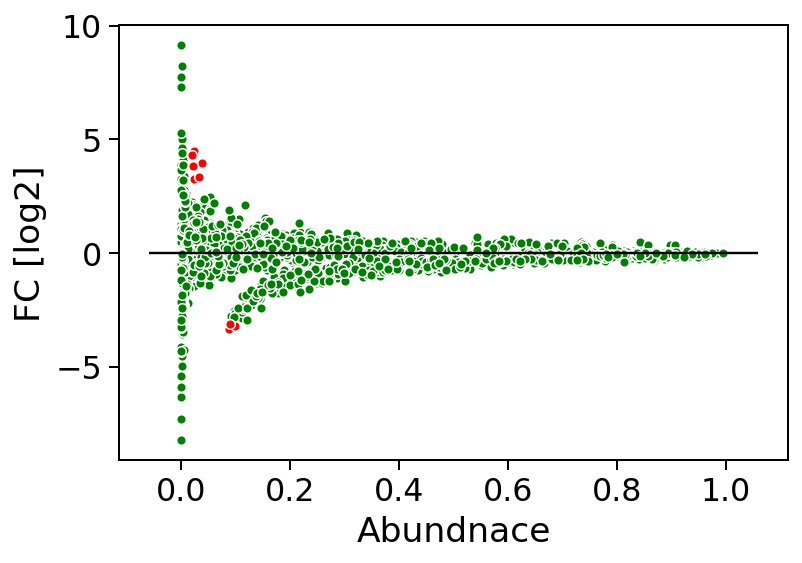

In [69]:
from adjustText import adjust_text

def MA_plot(abundance,change,sig=None,ax=None):
    
    if ax is None:
        ax = plt.subplot(111)
        
    abundance= pd.Series(abundance)
    change= pd.Series(change)

    sns.scatterplot(abundance,change,
                    color='g',ax=ax)
    if sig is not None:
        sns.scatterplot(abundance.loc[sig],change.loc[sig],color='r',ax=ax)
    
    ax.set_xlabel('Abundnace')
    ax.set_ylabel('FC [log2]')
    ax.hlines(0,*ax.get_xlim())
    
    #ax.fill_between(ax.get_xlim(),-1,1,alpha=0.5,color='grey')

#f, axe = plt.subplots(1,2,figsize=(15,5),sharey=True)
    
#MA_plot(Stats['median_diff'][Source],Effect,sig)
MA_plot(Ab[Source],Effect[Source],sig)


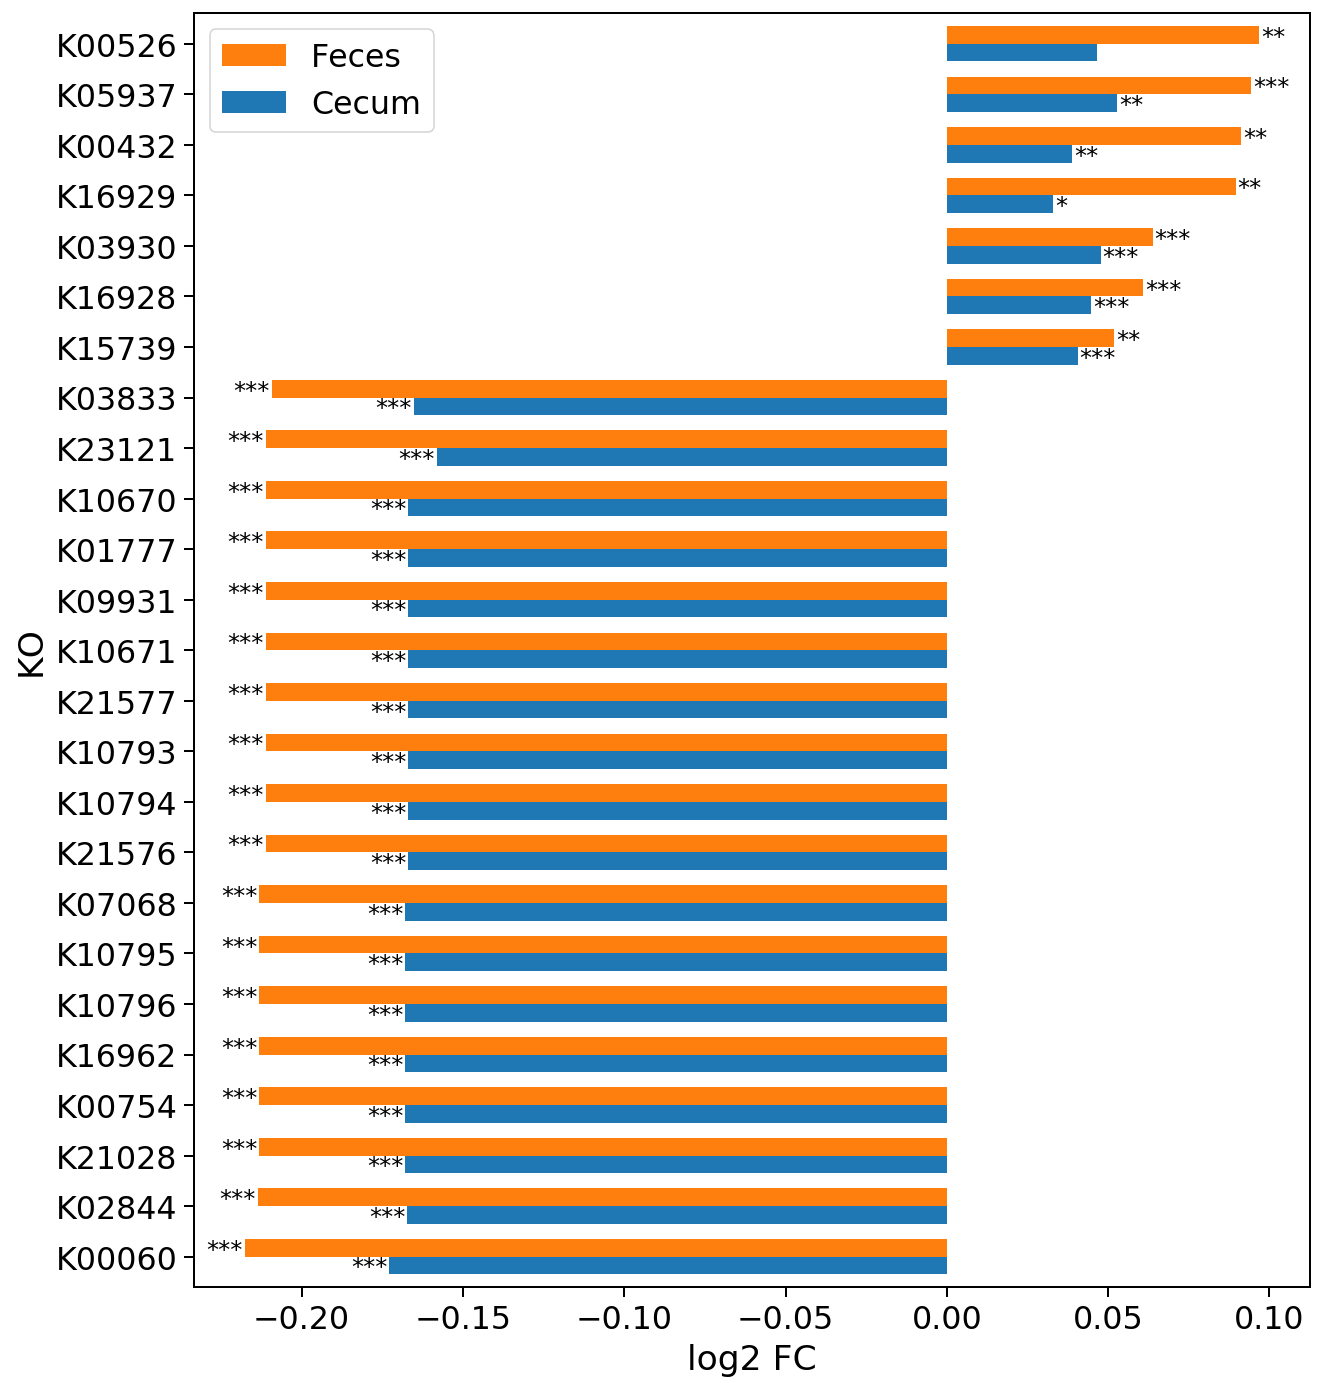

In [70]:
EP.effect_plot(Stats['median_diff'].loc[sig], Stats.loc[sig,'pBH'],Labels=Description)
_= plt.xlabel('log2 FC')

#hs.plotting.saveplot('Effectplot',figurefolder='Figures')

K00797 K00797


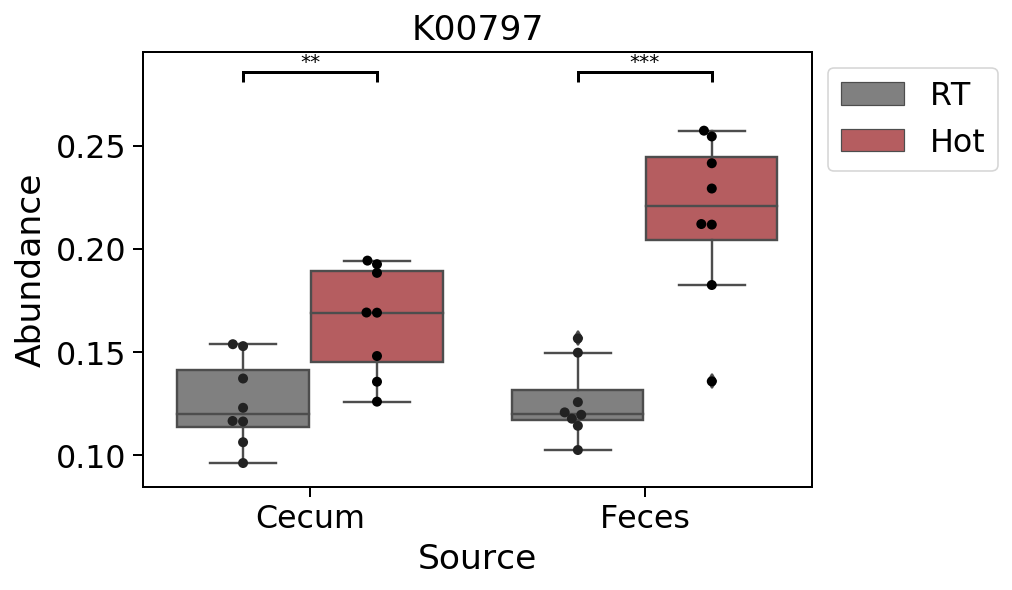

In [178]:
goi= sig[-1] #'GenProp1337'
print(goi,Description[goi])


M.boxplot(goi,distance_between_sig_labels=0)
ax= plt.gca()
ax.set_title(ax.get_ylabel())
_=ax.set_ylabel('Abundance')

In [118]:
MAGs_with_pathway=presence_absence.query(f'{goi}==1').index

/Users/silas/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0.5, 0, 'Cecum                     Feces')

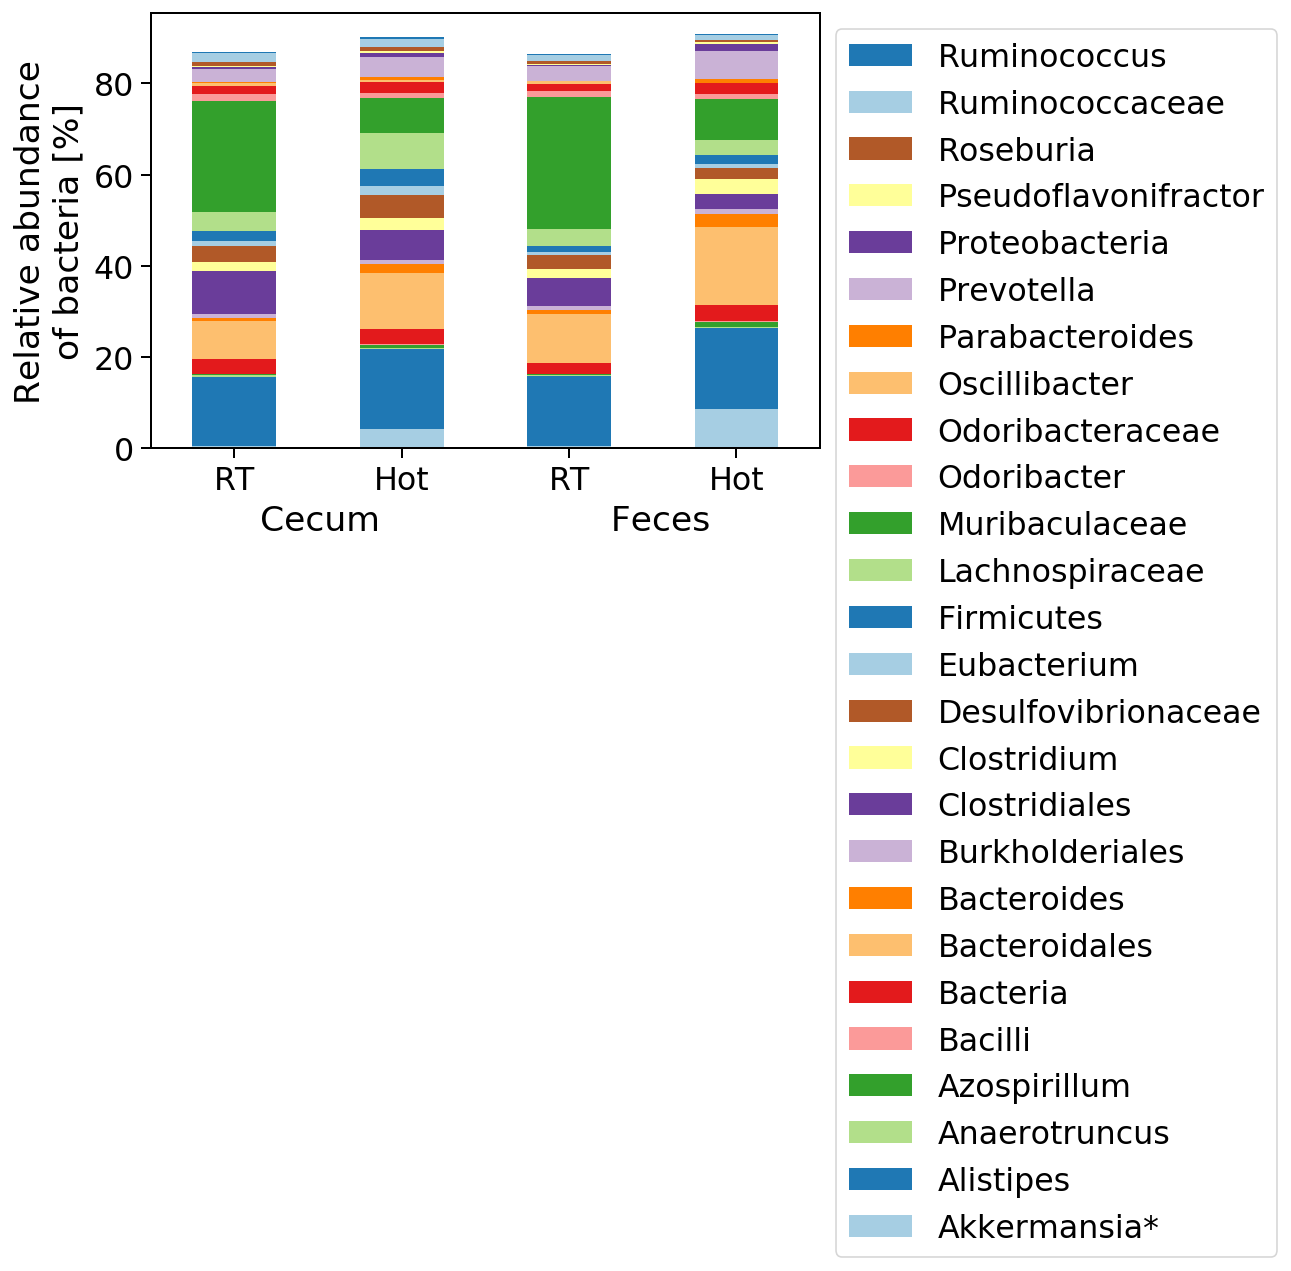

In [157]:
MAGs_with_pathway=presence_absence.index[presence_absence.loc[:,sig].any(1)]

sns.set_palette('Paired')

plot_data= D[MAGs_with_pathway].groupby(Tax.genus,axis=1).sum().groupby([metadata.Source,metadata.Group]).mean()
plot_data=plot_data.loc[[('Cecum', 'RT'),('Cecum', 'Hot'),('Feces', 'RT'), ('Feces', 'Hot')]]
plot_data= plot_data.loc[:,plot_data.max()>0.001]*100
ax=plot_data.plot.bar(stacked=True)
handles, labels=ax.get_legend_handles_labels()

ax.legend(reversed(handles),reversed(labels),bbox_to_anchor=(1,1))

ax.set_ylabel('Relative abundance\nof bacteria [%]')
ax.set_xticklabels(['RT','Hot']*2,rotation=0)
ax.set_xlabel('Cecum                     Feces')
#ax.set_title(Description[goi]+' by Genus')
#ax.set_title(label+' by Genus')

#hs.plotting.saveplot((label+' by Genus').replace(' ','_'),**plot_params)

In [50]:
checkmTax.loc['MAG044']

Kindom         k__Bacteria
Phylum    p__Bacteroidetes
Class       c__Bacteroidia
Order     o__Bacteroidales
Family    f__Rikenellaceae
Genus         g__Alistipes
Name: MAG044, dtype: object

In [123]:
data=Genes.copy()

/Users/silas/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: The condensed distance matrix must contain only finite values.

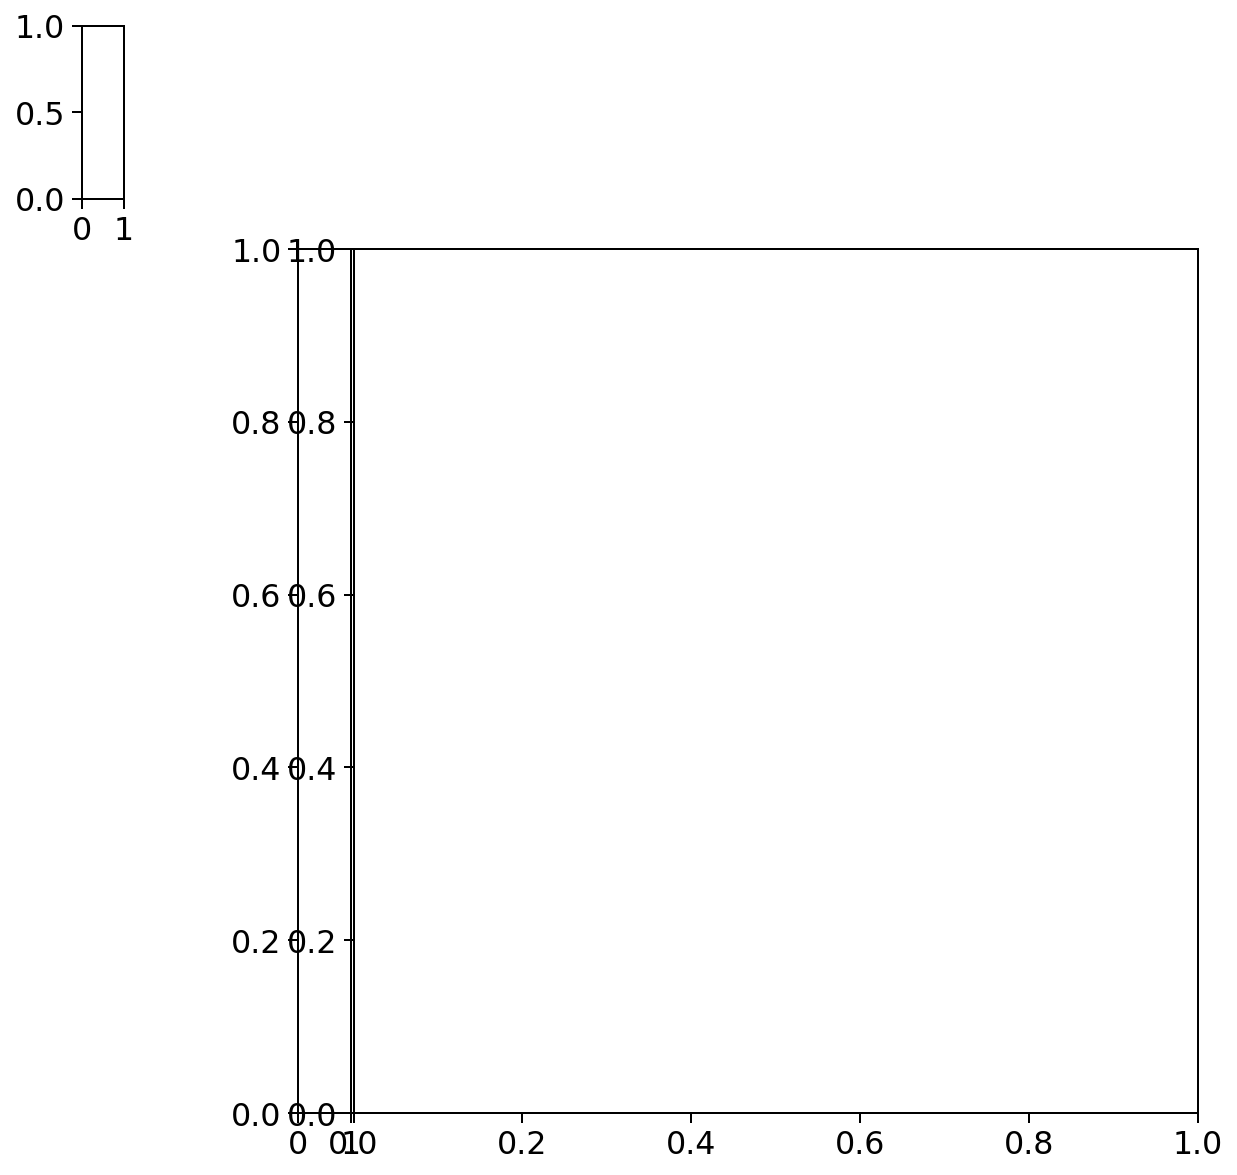

In [124]:
colors=M.test_variable.map(dict(zip(M.order_test,M.colors)) )
sns.clustermap(Genes.loc[metadata.Source==Source,sig],row_colors=colors)

In [178]:
Description.name='Description'

# check abundance

In [1]:
genes_of_interest= pd.read_excel('../KEGGgenes/kegg_enzymes.xlsx',index_col=0)

NameError: name 'pd' is not defined

In [2]:
genes_of_interest

NameError: name 'genes_of_interest' is not defined

/Users/silas/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KEGG NAME
K03757    cadaverine:lysine antiporter cadB
K14052             puuP,putrescine importer
Name: ENYZME NAME, dtype: object


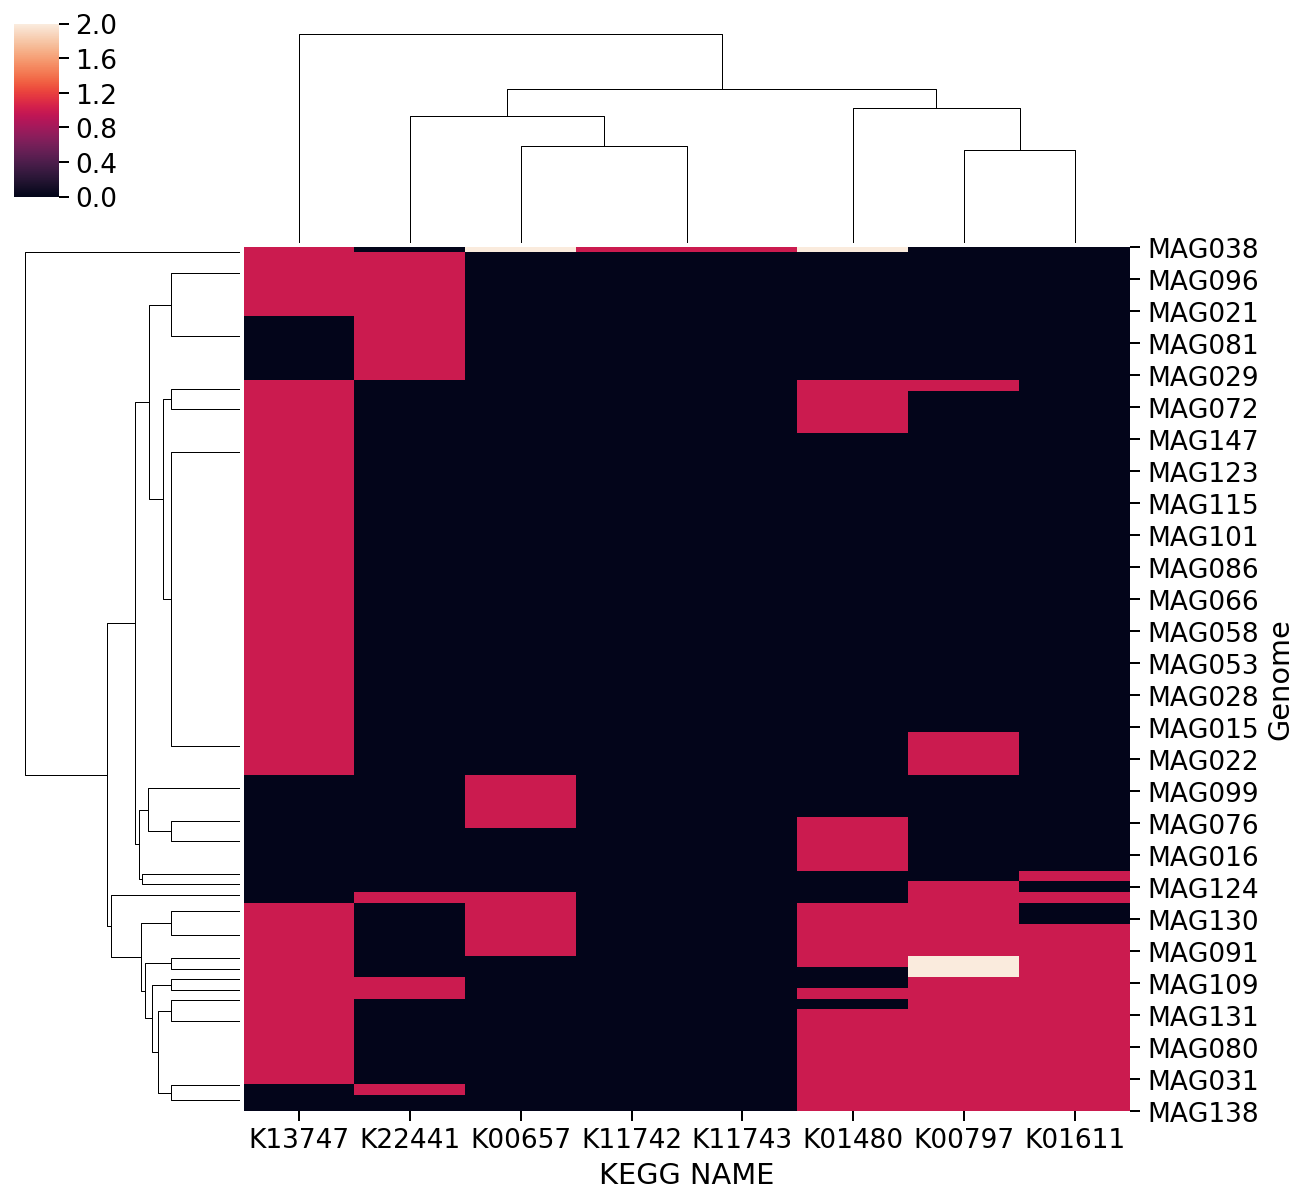

In [90]:
df=K.loc[:,genes_of_interest.index]
print(genes_of_interest.loc[df.isnull().any(),'ENYZME NAME'])

df= df.loc[df.sum(1)>0,df.sum(0)>0]
sns.clustermap(df)


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

genus= Tax.loc[df.index,"genus"].unique()
TaxColors= pd.Series(sns.color_palette("Paired",n_colors=len(genus)),index=sorted(genus))

with PdfPages('../KEGGgenes/results.pdf') as pdf:
    for k in df.columns:
    
    
        
        plot_data= D[df.index[df[k]>0]].groupby(Tax.genus,axis=1).sum().groupby([metadata.Source,metadata.Group]).mean()

        plot_data=plot_data.loc[[('Cecum', 'RT'),('Cecum', 'Hot'),('Feces', 'RT'), ('Feces', 'Hot')]]
        plot_data= plot_data.loc[:,plot_data.max()>0.001]*100
        ax=plot_data.plot.bar(stacked=True,color=TaxColors[plot_data.columns],figsize=(8, 5))
        handles, labels=ax.get_legend_handles_labels()

        ax.legend(reversed(handles),reversed(labels),bbox_to_anchor=(1,1))

        ax.set_ylabel('Relative abundance\nof bacteria [%]')
        ax.set_xticklabels(['RT','Hot']*2,rotation=0)
        ax.set_xlabel('Cecum                     Feces')
        ax.set_title(k+" "+genes_of_interest.loc[k,'ENYZME NAME'])
        
        plt.tight_layout()
    
        pdf.savefig()
        plt.show()

In [133]:
!open ../KEGGgenes/results.pdf